In [39]:
# %load_ext pycodestyle_magic
# %%pycodestyle
# https://stackoverflow.com/a/54278757

import pandas as pd
import numpy as np

weo_subject_code = 'WEO Subject Code'
estimates_after = 'Estimates Start After'
iso_col = 'ISO'
country_name = 'Country'
usecols = [iso_col, weo_subject_code, country_name]
for i in range(1980,2020):
    usecols.append(str(i))
usecols.append(estimates_after)

df = pd.read_table(
    'WEOOct2020all.xls',
    # nrows=10,
    encoding='UTF-16-LE',
    usecols=usecols,
    thousands=','
)

gdppc = 'NGDPRPPPPC'

gdp_per_capita_common_dollar = lambda col: col[weo_subject_code] == gdppc

# https://stackoverflow.com/a/64307654
#df[gdp_per_capita_common_dollar].values
# for i, row in enumerate(df[gdp_per_capita_common_dollar].values):
#     if row[2] < 1:
#         print(i,row)

# df_only_iso =  df[gdp_per_capita_common_dollar][iso_col]
# df_only_iso


In [40]:
df2 = df.loc[lambda df: df[weo_subject_code] == gdppc]
min(df2.loc[lambda df: df[estimates_after] > 0][estimates_after])
max(df2.loc[lambda df: df[estimates_after] > 0][estimates_after])


2020.0

In [41]:
# import numpy as np

# for i,row in enumerate(df2.values):
#     if i > 10:
#         break
#     print(i, np.count_nonzero(np.isnan(row)))
oecd_countries_all_caps = {'AUSTRIA':'',
'AUSTRALIA':'',
'BELGIUM':'',
'CANADA':'',
'CHILE':'',
'COLOMBIA':'',
'CZECH REPUBLIC':'',
'DENMARK':'',
'ESTONIA':'',
'FINLAND':'',
'FRANCE':'',
'GERMANY':'',
'GREECE':'',
'HUNGARY':'',
'ICELAND':'',
'IRELAND':'',
'ISRAEL':'',
'ITALY':'',
'JAPAN':'',
'KOREA':'',
'LATVIA':'',
'LITHUANIA':'',
'LUXEMBOURG':'',
'MEXICO':'',
'NETHERLANDS':'',
'NEW ZEALAND':'',
'NORWAY':'',
'POLAND':'',
'PORTUGAL':'',
'SLOVAK REPUBLIC':'',
'SLOVENIA':'',
'SPAIN':'',
'SWEDEN':'',
'SWITZERLAND':'',
'TURKEY':'',
'UNITED KINGDOM':'',
'UNITED STATES':''}

oecd_countries = {}
for key in oecd_countries_all_caps:
    oecd_countries[key.title()] = ''
oecd_countries


{'Austria': '',
 'Australia': '',
 'Belgium': '',
 'Canada': '',
 'Chile': '',
 'Colombia': '',
 'Czech Republic': '',
 'Denmark': '',
 'Estonia': '',
 'Finland': '',
 'France': '',
 'Germany': '',
 'Greece': '',
 'Hungary': '',
 'Iceland': '',
 'Ireland': '',
 'Israel': '',
 'Italy': '',
 'Japan': '',
 'Korea': '',
 'Latvia': '',
 'Lithuania': '',
 'Luxembourg': '',
 'Mexico': '',
 'Netherlands': '',
 'New Zealand': '',
 'Norway': '',
 'Poland': '',
 'Portugal': '',
 'Slovak Republic': '',
 'Slovenia': '',
 'Spain': '',
 'Sweden': '',
 'Switzerland': '',
 'Turkey': '',
 'United Kingdom': '',
 'United States': ''}

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

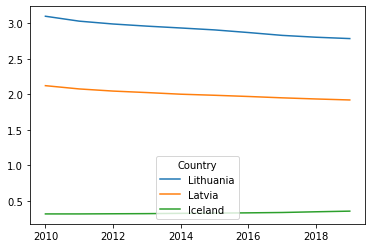

In [42]:
import matplotlib.pyplot as plt

'''
plot of OECD countries population
'''

population_key = 'LP'
# population_df = df.loc[ (df[weo_subject_code] == population_key) & (df[country_name] == 'Lithuania')]
population_df = df.loc[ (df[weo_subject_code] == population_key)]
# sets index and index is stored for future
population_df = population_df.set_index(country_name)
population_df = population_df.loc[oecd_countries]

# do not convert to string for filtering
# rather convert dataframe to floats
decade = []
for i in range(2010,2020):
    decade.append(str(i))

# https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html
population_df = population_df[decade]
population_df = population_df.T
# wrong data type is set needs to cast to numeris type
population_df = population_df.astype('float')
population_df = population_df[['Lithuania', 'Latvia', 'Iceland']]
#population_df = population_df.set_index('index')
# population_df = population_df.set_index(0)
#population_df
# population_df = population_df.cumsum()
plt.figure()
population_df.plot()


In [49]:
'''save all countries GDP in different PNG files'''

# Gross domestic product, current prices
# Values are based upon GDP in national currency converted to U.S. dollars
gdp_key = 'NGDPD'

gdp_df = df.loc[lambda df: df[weo_subject_code] == gdp_key]
gdp_df = gdp_df.set_index(country_name)

selected_cols = []

for col in gdp_df.columns:
    if col == iso_col or col == weo_subject_code or col == estimates_after:
       continue

    selected_cols.append(col)

gdp_df = gdp_df[selected_cols]
# https://stackoverflow.com/a/49896522
# applies lambda to colums
gdp_df = gdp_df.apply(lambda df: df.str.replace(',','').astype('float'),axis=0)
#gdp_df.dropna()
gdp_df


,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15.325,17.890,20.293,20.170,20.635,20.220,17.994,18.910,18.401,18.876
Albania,1.946,2.229,2.296,2.319,2.290,2.339,2.587,2.566,2.530,2.779,...,11.937,12.899,12.324,12.784,13.246,11.389,11.862,13.053,15.147,15.276
Algeria,42.346,44.372,44.780,47.529,51.513,61.132,61.535,63.300,51.664,52.558,...,161.207,200.251,209.016,209.755,213.810,165.979,160.034,167.390,173.757,169.267
Angola,6.639,6.214,6.214,6.476,6.864,8.457,7.918,9.050,9.818,11.421,...,83.799,111.790,128.053,136.710,145.712,116.194,101.124,122.124,105.902,89.417
Antigua and Barbuda,0.131,0.148,0.164,0.182,0.208,0.241,0.290,0.337,0.399,0.439,...,1.149,1.138,1.200,1.181,1.250,1.337,1.437,1.468,1.605,1.662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vietnam,35.357,17.617,23.369,35.204,61.171,19.045,43.009,53.385,29.501,7.991,...,143.257,171.368,195.168,212.738,232.893,236.840,252.149,277.074,304.016,329.537
West Bank and Gaza,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.682,11.182,12.204,13.502,13.976,13.967,15.403,16.117,16.300,17.051
Yemen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,30.907,32.726,35.401,40.415,43.229,42.445,30.934,26.736,23.486,22.568


In [67]:
''' find lowest common denominator for year 2015 '''
common_denominator_df = df[[weo_subject_code,'2015']]
common_denominator_df = common_denominator_df.dropna()
common_denominator_df = common_denominator_df[[weo_subject_code]]
common_denominator_df = common_denominator_df.groupby([weo_subject_code])

# common_denominator_df.apply(print)
# https://stackoverflow.com/a/36951842
for key in common_denominator_df.groups.keys():
   print(key)


BCA
BCA_NGDPD
FLIBOR6
GGR
GGR_NGDP
GGSB
GGSB_NPGDP
GGX
GGXCNL
GGXCNL_NGDP
GGXONLB
GGXONLB_NGDP
GGXWDG
GGXWDG_NGDP
GGXWDN
GGXWDN_NGDP
GGX_NGDP
LE
LP
LUR
NGAP_NPGDP
NGDP
NGDPD
NGDPDPC
NGDPPC
NGDPRPC
NGDPRPPPPC
NGDP_D
NGDP_FY
NGDP_R
NGDP_RPCH
NGSD_NGDP
NID_NGDP
PCPI
PCPIE
PCPIEPCH
PCPIPCH
PPPEX
PPPGDP
PPPPC
PPPSH
TMG_RPCH
TM_RPCH
TXG_RPCH
TX_RPCH


In [35]:
import io
t="""a,b,c
0,1,2
3,4,5"""
pd.read_csv(io.StringIO(t), header=0, usecols=['a'])


,a
0,0
1,3


In [36]:
%load_ext pycodestyle_magic


The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


In [37]:
oecd_countries = {'AUSTRIA'.title(),
'AUSTRALIA',
'BELGIUM',
'CANADA',
'CHILE',
'COLOMBIA',
'CZECH REPUBLIC',
'DENMARK',
'ESTONIA',
'FINLAND',
'FRANCE',
'GERMANY',
'GREECE',
'HUNGARY',
'ICELAND',
'IRELAND',
'ISRAEL',
'ITALY',
'JAPAN',
'KOREA',
'LATVIA',
'Lithuania',
'LUXEMBOURG',
'MEXICO',
'NETHERLANDS',
'NEW ZEALAND',
'NORWAY',
'POLAND',
'PORTUGAL',
'SLOVAK REPUBLIC',
'SLOVENIA',
'SPAIN',
'SWEDEN',
'SWITZERLAND',
'TURKEY',
'UNITED KINGDOM',
'UNITED STATES'}
oecd_countries


{'AUSTRALIA',
 'Austria',
 'BELGIUM',
 'CANADA',
 'CHILE',
 'COLOMBIA',
 'CZECH REPUBLIC',
 'DENMARK',
 'ESTONIA',
 'FINLAND',
 'FRANCE',
 'GERMANY',
 'GREECE',
 'HUNGARY',
 'ICELAND',
 'IRELAND',
 'ISRAEL',
 'ITALY',
 'JAPAN',
 'KOREA',
 'LATVIA',
 'LUXEMBOURG',
 'Lithuania',
 'MEXICO',
 'NETHERLANDS',
 'NEW ZEALAND',
 'NORWAY',
 'POLAND',
 'PORTUGAL',
 'SLOVAK REPUBLIC',
 'SLOVENIA',
 'SPAIN',
 'SWEDEN',
 'SWITZERLAND',
 'TURKEY',
 'UNITED KINGDOM',
 'UNITED STATES'}

In [38]:
plt.close('all')

ts = pd.Series(np.random.randn(1000),
   index=pd.date_range('1/1/2000', periods=1000))

#ts
# ts = ts.cumsum()
# ts.plot()

# plot_test_df = pd.DataFrame(np.random.randn(1000, 4),
#    index=ts.index, columns=list('ABCD'))

#plot_test_df


#plot_test_df = plot_test_df.cumsum()

# plt.figure()

# plot_test_df.plot()